In [1]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# NOTE: Whenever lambda functions are used, we create default variables when accessing
# outside variables. This is explained here: https://docs.python.org/3/faq/programming.html#id11

### Helper functions

In [2]:
def emp_wasserstein2(u: np.array, v: np.array):
    """
    Returns the squared 2-Wasserstein distance between two
    empirical distributions represented by arrays.
    Assumes the arrays of equal size.
    """
    assert len(u) == len(v)
    
    u_sorted = np.sort(u)
    v_sorted = np.sort(v)
    
    return np.sum(np.power(u_sorted - v_sorted,2)) / len(u)

def dissim(list1: list[np.array], list2: list[np.array]) -> float:
    """
    Returns a dissimilarity measure between two lists of
    data arrays. Only measures dissimilarity between
    lists that are observed.
    
    If no observations overlap then returns infinity.
    Else returns the average 2-wasserstein distance.
    """
    size = 0
    distance = 0
    for ind in range(len(list1)):
        if len(list1[ind]) > 0 and len(list2[ind]) > 0: # both are observed
            distance += emp_wasserstein2(list1[ind],list2[ind])
            size += 1
    if size == 0:
        return float('inf')
    return distance / size

def get_col(table, col):
    """
    Utility function to get the column of a table
    as a 1-dim list.
    """
    return [table[i][col] for i in range(len(table))]

def barycenter(lists):
    """
    Returns the barycenter of a list of empirical distributions
    with the same number of samples.
    
    This is just the average of the order statistics of
    each empirical distribution.
    """
    for i in range(len(lists)):
        for j in range(i+1,len(lists)):
            assert len(lists[i]) == len(lists[j])
    
    sorted_data = [np.sort(l) for l in lists]
    
    sum_data = 0
    for l in sorted_data:
        sum_data += l
    
    return sum_data / len(lists)

The 2-Wasserstein metric has a closed-form solution in the 1-dimensional case:

$$W_2(\mu_1,\mu_2) = \left(\int_0^1 \left|F^{-1}_1(q) - F^{-1}_2(q)\right|^2\right)^{1/2}$$

where $F^{-1}_1$ and $F^{-1}_2$ are quantile functions for the distributions.

In [3]:
from scipy.integrate import quad
from scipy.stats import norm
from functools import partial
from numpy import quantile

def wasserstein2(inv_cdf1, inv_cdf2):
    """
    Compute the squared 2-Wasserstein metric.
    """
    # Combine the inner part of the integral into one function
    # Estimate integral via quadrature
    return quad(lambda x : (inv_cdf1(x) - inv_cdf2(x)) ** 2, 0, 1)

def empirical_quantile(data_arr):
    """
    Returns a function handle for the empirical quantile
    function given a 1-d dataset.
    """
    return lambda q, data_arr = data_arr : quantile(data_arr, q, method = 'inverted_cdf')

def normal_ppf(mean, std):
    return lambda q, mean = mean, std = std : norm.ppf(q, loc = mean, scale = std)

In [60]:
data = np.random.normal(0,1,100000) # draw samples from N(0,1) 
emp_quan = empirical_quantile(data) # create empirical quantile function
norm_ppf = normal_ppf(0,1) # percent point function (quantile function) of N(0,1)

y, err = wasserstein2(emp_quan, norm_ppf)

print(y)

3.667538166591077e-05


-0.01843372015826582 0.9875565681761207 -0.00014269772110434787 0.9942565784701538
0.043259641599877365
0.012251823357599638


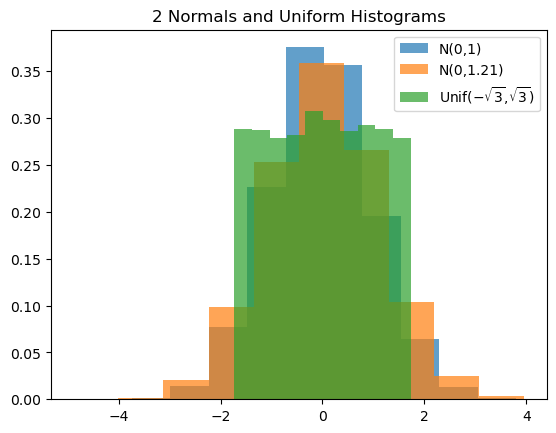

In [76]:
np.random.seed(0)
norm_data = np.random.normal(0,1,10000)
norm_data2 = np.random.normal(0,1.1,10000)
unif_data = np.random.uniform(-np.sqrt(3), np.sqrt(3), 10000)

print(np.mean(norm_data), np.std(norm_data), np.mean(unif_data), np.std(unif_data))
print(emp_wasserstein2(norm_data, unif_data))
print(emp_wasserstein2(norm_data, norm_data2))

alpha = 0.7
plt.hist(norm_data, alpha = alpha, density = True)
plt.hist(norm_data2, alpha = alpha, density = True)
plt.hist(unif_data, alpha = alpha, density = True)
plt.legend(["N(0,1)", "N(0,1.21)", "Unif($-\sqrt{3}$,$\sqrt{3}$)"])
plt.title("2 Normals and Uniform Histograms")
plt.savefig("normal_unif_wasserstein.pdf")
plt.show()

### Generate Data

In [218]:
r = 3
c = 4
n = 200

np.random.seed(0)

data_table = [[0 for i in range(c)] for j in range(r)]

# Table of n x m Gaussians with columns having same variance and rows having same means

# means = np.linspace(-10,10,num=r) # means
# stds = np.linspace(1, 20, num=c) # variances
means = [0, 10, 0] # means
stds = [1, 2, 1, 3] # variances

for i, j in product(range(r),range(c)):
    data_table[i][j] = np.random.normal(means[i],stds[j], n)

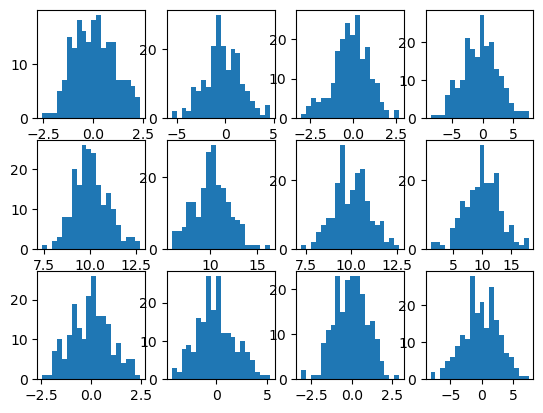

In [219]:
fig, axs = plt.subplots(r, c)

for i in range(r):
    for j in range(c):
        axs[i, j].hist(data_table[i][j], bins=n // 10)

In [71]:
print("(row,col): mean, std\n")
for i, j in product(range(r),range(c)):
    print(f"({i}, {j}): {np.mean(data_table[i][j]):.2f}, {np.std(data_table[i][j]):.2f}")

(row,col): mean, std

(0, 0): 0.06, 1.01
(0, 1): 0.16, 2.07
(0, 2): -0.06, 0.95
(1, 0): -0.20, 0.93
(1, 1): -0.03, 2.07
(1, 2): -0.20, 1.02
(2, 0): -0.13, 1.00
(2, 1): -0.25, 1.88
(2, 2): -0.03, 0.93


In [220]:
# Dissimilarity between columns 0 and 1
dissim(data_table[0], data_table[1])

104.92360687183194

In [221]:
dissim(data_table[0], data_table[2])

0.05905770706077636

In [108]:
# Dissimilarity between columns 0 and 2
dissim(get_col(data_table, 0), get_col(data_table, 2))

0.029995141477042714

In [109]:
dissim(get_col(data_table, 0), get_col(data_table, 3))

3.627370455819621

The dissimilarity between columns 0 and 2 is much lower because they have the same means and standard deviations whereas column 1 has a higher standard deviation of 2.

### Wasserstein Barycenter

In [5]:
row1_bc = barycenter(data_table[0])

np.mean(row1_bc), np.std(row1_bc)

NameError: name 'data_table' is not defined

The barycenter's mean is close to 0 and the standard deviation is close to the average of the standard deviations in the first row (1,2, and 1).

In [106]:
bc = barycenter(get_col(data_table, 0)[1:])

np.mean(bc), np.std(bc)

(-0.020381673797150678, 0.9805277954029583)

### Masking Matrix

In [95]:
from copy import deepcopy

Z = deepcopy(data_table)

Z[0][0] = []

## Data Generating Model

Each distribution is generated from a finite number of functions in the $L^2_\mu$ space mapped to the $W^2(\Omega)$ space via the exponential mapping with respect to a reference measure.

In [5]:
def push_forward_empirical(f, samples: np.array):
    """
    Empirical push-forward distribution.
    Takes a function and samples to map through the function.
    """
    return np.fromiter((f(s) for s in samples), samples.dtype)

def exp_map_empirical(f, samples):
    """
    Empirical exponential map.
    Takes a function and samples representing a distribution.
    """
    return push_forward_empirical(lambda x, f = f: f(x) + x, samples)

def log_map(quantile, ref_cdf):
    """
    Logarithmic map.
    Takes two quantile functions for distributions and maps to a function in L^2.
    """
    return lambda x, ref_cdf = ref_cdf : quantile(ref_cdf(x)) - x

Geodesics in the wasserstein space are interpolations between distributions. So, we need 2 distributions to create a geodesic. Then we can map these geodesics to the $L^2$ space using a reference measure.

Let $\gamma: [0,1] \to W_2(\Omega)$ be a curve and let $v_0 = \log_\mu(\gamma(0))$, $v_1 = \log_\mu(\gamma(1))$. Then $\gamma$ is a geodesic if and only if $\gamma(t) = \exp_\mu((1-t)v_0 + t v_1)$ for all $t\in [0,1]$.

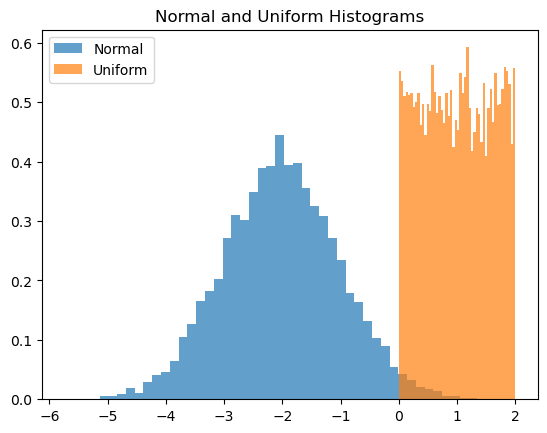

In [77]:
n = 10000

np.random.seed(0)
data1 = np.random.normal(loc = -2, scale = 1, size = n)
data2 = np.random.uniform(low = 0, high = 2, size = n)

plt.hist(data1, bins = 50, alpha = 0.7, density = True)
plt.hist(data2, bins = 50, alpha = 0.7, density = True)
plt.title("Normal and Uniform Histograms")
plt.legend(["Normal", "Uniform"])
plt.savefig("normal_uniform_hist.pdf")
plt.show()

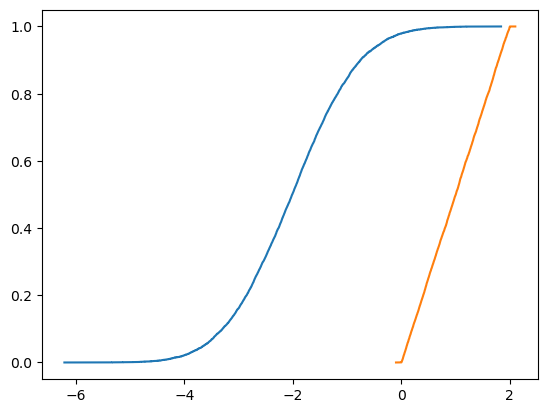

In [16]:
from scipy.stats import ecdf

cdf1 = ecdf(data1)
cdf2 = ecdf(data2)

ax = plt.subplot()

cdf1.cdf.plot(ax)
cdf2.cdf.plot(ax)
plt.show()

In [10]:
import scipy.stats as stats

def interpolate(f1, f2, t: float):
    return lambda x, g1 = f1, g2 = f2, s = t: ((1-s) * g1(x)) + (s * g2(x))

In [11]:
reference_mean = 0
reference_std = 1

ref_cdf = lambda x, reference_mean = reference_mean, reference_std = reference_std : stats.norm.cdf(x, loc = reference_mean, scale = reference_std)
ref_samples = np.random.normal(reference_mean,reference_std,10000)

q1 = empirical_quantile(data1)
q2 = empirical_quantile(data2)

f1 = log_map(q1, ref_cdf)
f2 = log_map(q2, ref_cdf)

def exp_log_interp(f1, f2, t, ref_samples):
    mid_f = interpolate(f1,f2,t)
    exp_samples = exp_map_empirical(mid_f, ref_samples)
    exp_mid_cdf = ecdf(exp_samples)
    
    return exp_mid_cdf

mid_cdf1 = exp_log_interp(f1, f2, 0.25, ref_samples)
mid_cdf2 = exp_log_interp(f1, f2, 0.5, ref_samples)
mid_cdf3 = exp_log_interp(f1, f2, 0.75, ref_samples)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


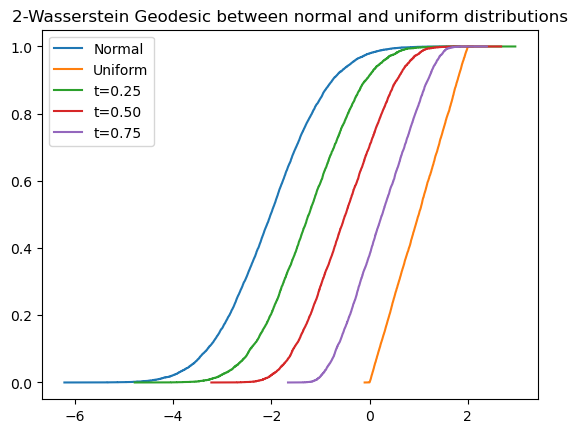

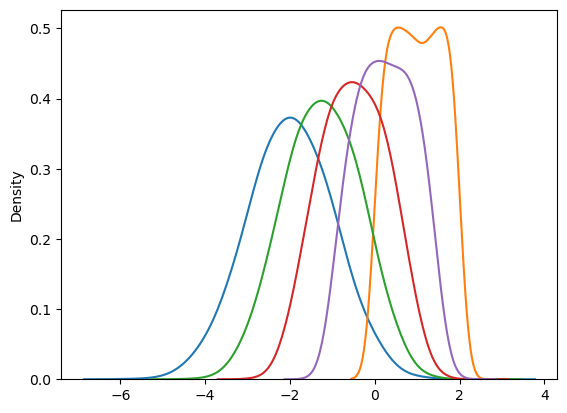

In [18]:
ax = plt.subplot()

cdf1.cdf.plot(ax)
cdf2.cdf.plot(ax)
mid_cdf1.cdf.plot(ax)
mid_cdf2.cdf.plot(ax)
mid_cdf3.cdf.plot(ax)

plt.title("2-Wasserstein Geodesic between normal and uniform distributions")
plt.legend(["Normal", "Uniform", "t=0.25", "t=0.50", "t=0.75"])
plt.savefig("normal_uniform_cdf_interp.eps")

plt.figure()
bw_adjust = 2.0
sns.kdeplot(exp_map_empirical(interpolate(f1,f2,0), ref_samples), bw_adjust=bw_adjust)
sns.kdeplot(exp_map_empirical(interpolate(f1,f2,1.0), ref_samples), bw_adjust=bw_adjust)
sns.kdeplot(exp_map_empirical(interpolate(f1,f2,0.25), ref_samples), bw_adjust=bw_adjust)
sns.kdeplot(exp_map_empirical(interpolate(f1,f2,0.5), ref_samples), bw_adjust=bw_adjust)
sns.kdeplot(exp_map_empirical(interpolate(f1,f2,0.75), ref_samples), bw_adjust=bw_adjust)
plt.savefig("normal_uniform_kde.eps")

plt.show()

This is equivalent to an interolation between the quantile functions (the "inverse" CDF's). So, the graphs look averaged along the x-axis.

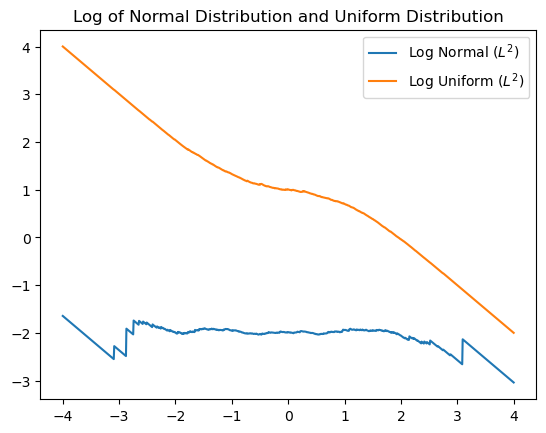

In [13]:
x = np.linspace(-4,4,1000)
plt.plot(x, [f1(xi) for xi in x])
plt.plot(x, [f2(xi) for xi in x])
plt.title("Log of Normal Distribution and Uniform Distribution")
plt.legend(["Log Normal ($L^2$)", "Log Uniform ($L^2$)"])
plt.show()

As far as I can see, these functions have no inherent meaning. It allows us to work with functions in a Hilbert space. I think the normal distirbution looks almost constant because the reference distribution is a standard normal.

### Data Generating Model - Normal Means and Normal Different Variances
We will have the column space contain functions that map to normal distributions and the row space contain functions that map to uniform distributions. We will then combine them via a tensor product and see what we get.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


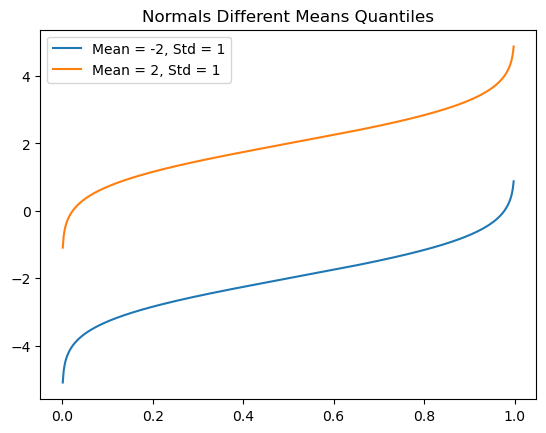

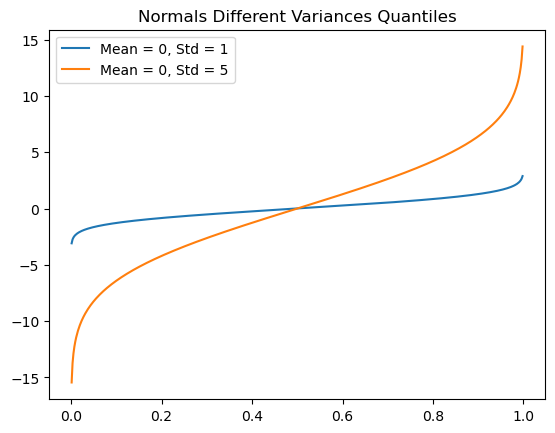

In [50]:
# Different means
mean_ppf_1 = lambda x : stats.norm.ppf(x, loc = -2, scale = 1)
mean_ppf_2 = lambda x : stats.norm.ppf(x, loc = 2, scale = 1)

# Different variances
var_ppf_1 = lambda x : stats.norm.ppf(x, loc = 0, scale = 1)
var_ppf_2 = lambda x : stats.norm.ppf(x, loc = 0, scale = 5)

x = np.linspace(-1,1,1000)
plt.figure()
plt.plot(x,mean_ppf_1(x))
plt.plot(x,mean_ppf_2(x))
plt.title("Normals Different Means Quantiles")
plt.legend(["Mean = -2, Std = 1", "Mean = 2, Std = 1"])
plt.savefig("normals_means.eps")
plt.figure()
plt.plot(x,var_ppf_1(x))
plt.plot(x,var_ppf_2(x))
plt.title("Normals Different Variances Quantiles")
plt.legend(["Mean = 0, Std = 1", "Mean = 0, Std = 5"])
plt.savefig("normals_stds.eps")
plt.show()

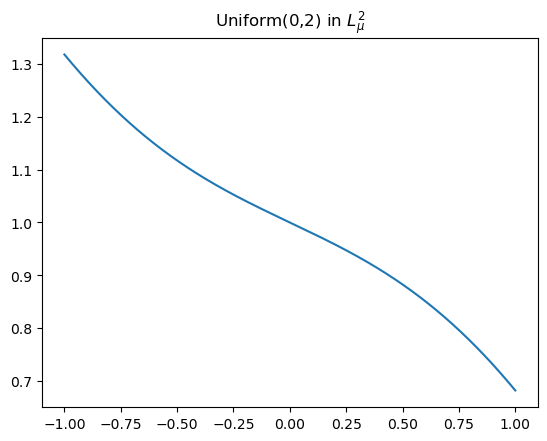

In [48]:
unif_log = log_map(lambda x : stats.uniform.ppf(x, scale = 2), ref_cdf)

plt.plot(x,unif_log(x))
plt.title("Uniform(0,2) in $L^2_\mu$")
plt.savefig("normals_stds.eps")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


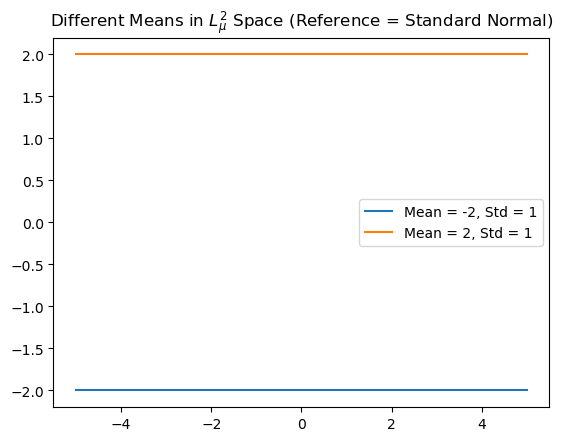

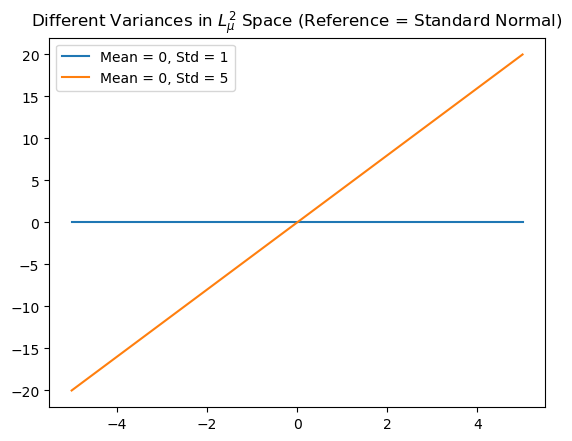

In [49]:
# Convert to L2 space
ref_cdf = lambda x : stats.norm.cdf(x, loc = 0, scale = 1)

mean_f1 = log_map(mean_ppf_1, ref_cdf)
mean_f2 = log_map(mean_ppf_2, ref_cdf)
var_f1 = log_map(var_ppf_1, ref_cdf)
var_f2 = log_map(var_ppf_2, ref_cdf)

x = np.linspace(-5,5,1000)
plt.figure()
plt.plot(x,mean_f1(x))
plt.plot(x,mean_f2(x))
plt.title("Different Means in $L^2_\mu$ Space (Reference = Standard Normal)")
plt.legend(["Mean = -2, Std = 1", "Mean = 2, Std = 1"])
plt.savefig("normal_means_l2.eps")
plt.figure()
plt.plot(x,var_f1(x))
plt.plot(x,var_f2(x))
plt.title("Different Variances in $L^2_\mu$ Space (Reference = Standard Normal)")
plt.legend(["Mean = 0, Std = 1", "Mean = 0, Std = 5"])
plt.savefig("normal_stds_l2.eps")

plt.show()

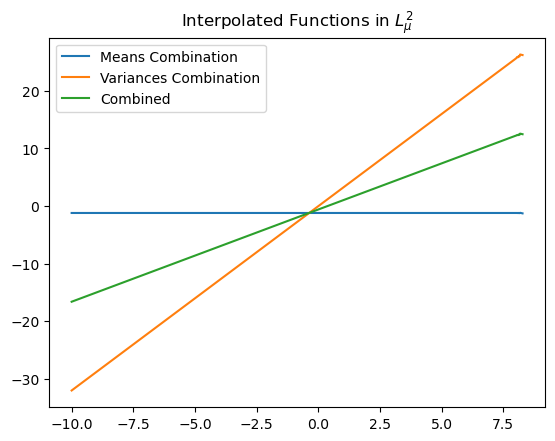

In [55]:
# Take a bunch of combinations of these functions
f_mean_comb = interpolate(mean_f1, mean_f2, 0.2)
f_var_comb = interpolate(var_f1, var_f2, 0.8)

f_comb = lambda x, f_mean_comb =  f_mean_comb, f_var_comb = f_var_comb: 0.5 * (f_mean_comb(x) + f_var_comb(x))

plt.plot(x, f_mean_comb(x))
plt.plot(x, f_var_comb(x))
plt.plot(x, f_comb(x))
plt.title("Interpolated Functions in $L^2_\mu$")
plt.legend(["Means Combination", "Variances Combination", "Combined"])
plt.show()

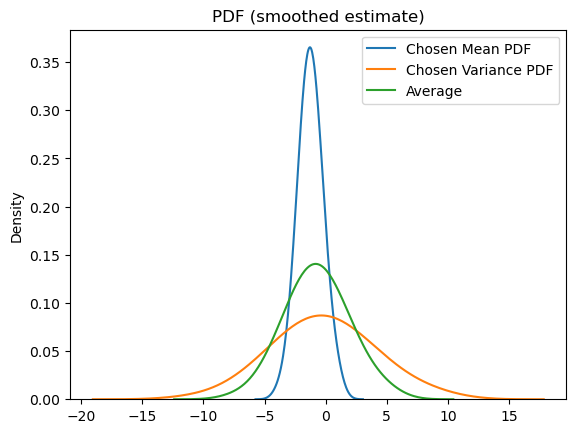

In [56]:
import seaborn as sns

# Interpolated functions back in the Wasserstein space
np.random.seed(0)
ref_samples = np.random.normal(0,1,1000)

bins = 100

sns.kdeplot(exp_map_empirical(f_mean_comb, ref_samples), bw_adjust=bw_adjust)
sns.kdeplot(exp_map_empirical(f_var_comb, ref_samples), bw_adjust=bw_adjust)
sns.kdeplot(exp_map_empirical(f_comb, ref_samples), bw_adjust=bw_adjust)

plt.title("PDF (smoothed estimate)")
plt.legend(["Chosen Mean PDF", "Chosen Variance PDF", "Average"])
plt.show()

### Data Table

In [51]:
# Let's create a dataset
num_rows = 3
num_cols = 3

t_row = [0, 0.1, 1]
t_col = [0, 0.1, 1]

row_log_f = []
col_log_f = []

for i in range(num_rows):
    row_log_f.append(interpolate(mean_f1, mean_f2, t_row[i]))
    
for j in range(num_cols):
    col_log_f.append(interpolate(var_f1, var_f2, t_col[j]))

log_f_table = {}

for i, j in product(range(num_rows), range(num_cols)):
    log_f_table[(i,j)] = lambda x, i = i, j = j : (row_log_f[i](x) + col_log_f[j](x)) * 0.5

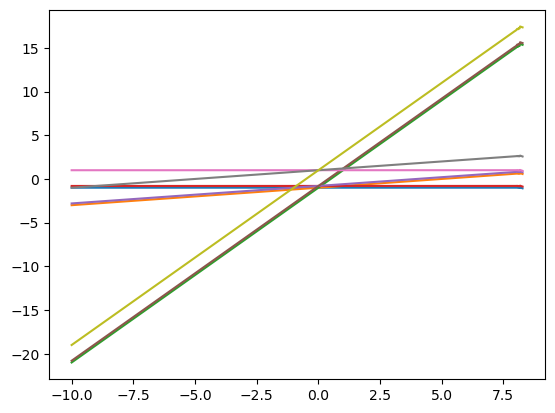

In [52]:
x = np.linspace(-10,10,1000)

for i, j in product(range(num_rows), range(num_cols)):
    plt.plot(x, log_f_table[i,j](x))

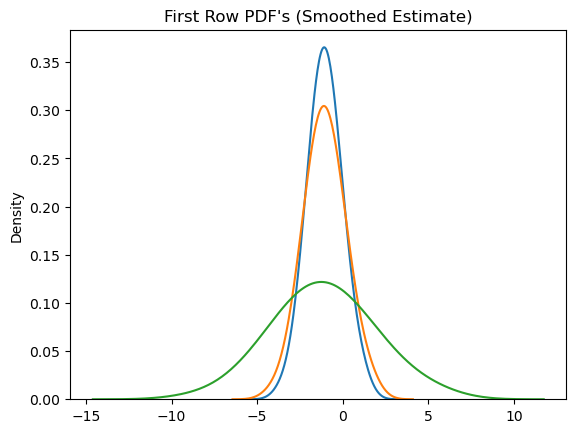

In [57]:
plt.title("First Row PDF's (Smoothed Estimate)")
for j in range(num_cols):
    sns.kdeplot(exp_map_empirical(log_f_table[0,j], ref_samples), bw_adjust=bw_adjust)
plt.show()

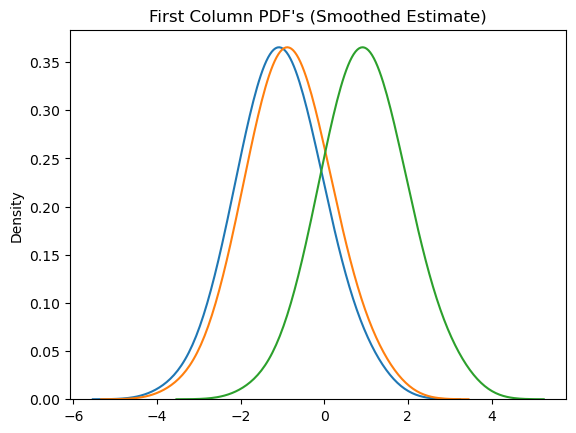

In [58]:
plt.title("First Column PDF's (Smoothed Estimate)")
for i in range(num_rows):
    sns.kdeplot(exp_map_empirical(log_f_table[i,0], ref_samples), bw_adjust=bw_adjust)
plt.show()

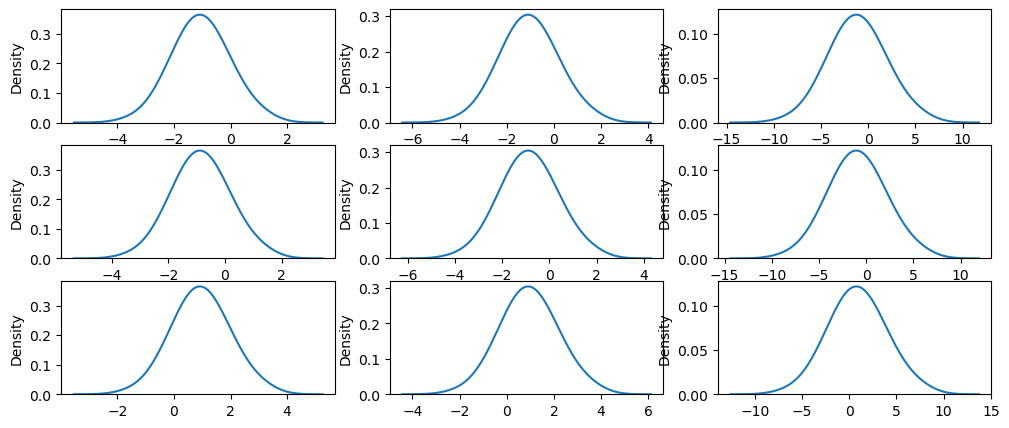

In [59]:
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figheight(5)
fig.set_figwidth(12)

for i, j in product(range(num_rows), range(num_cols)):
    sns.kdeplot(exp_map_empirical(log_f_table[i,j], ref_samples), ax = axs[i,j], bw_adjust=bw_adjust)
    
plt.show()

Here, we distribute the means and variances uniformly to show that we can generate this kind of dataset easily. This leads to now row or columns being similar, but shows how we can easily use geodesics to create a dataset of probability distributions.

With this generative model, we can create distributions with common aspects across rows and columns. These aspects are geodesics in the Wasserstein space and lines in the L2 space.

## Data Table with Normal and Exponential

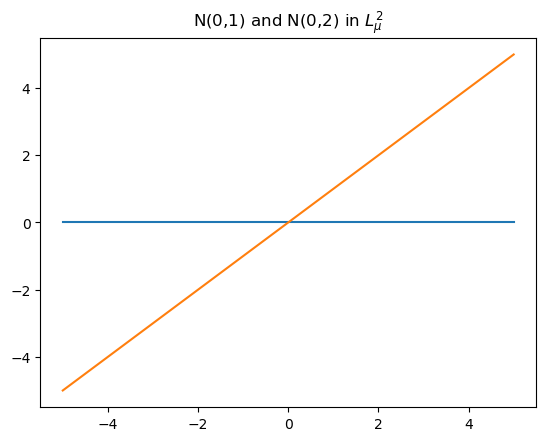

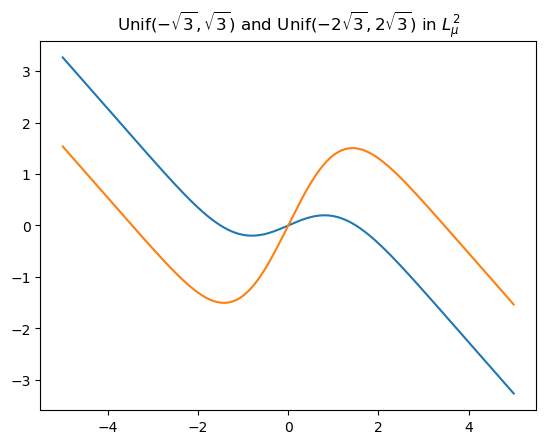

In [82]:
ref_cdf = lambda x : stats.norm.cdf(x, loc = 0, scale = 1) # N(0,1)

# Different Normals
norm_ppf_1 = lambda x : stats.norm.ppf(x, loc = 0, scale = 1)
norm_ppf_2 = lambda x : stats.norm.ppf(x, loc = 0, scale = 2)

# Different Uniforms
unif_ppf_1 = lambda x : stats.uniform.ppf(x, loc = -np.sqrt(3), scale = 2 * np.sqrt(3))
unif_ppf_2 = lambda x : stats.uniform.ppf(x, loc = -2 * np.sqrt(3), scale = 4 * np.sqrt(3))

norm_f1 = log_map(norm_ppf_1, ref_cdf)
norm_f2 = log_map(norm_ppf_2, ref_cdf)
unif_f1 = log_map(unif_ppf_1, ref_cdf)
unif_f2 = log_map(unif_ppf_2, ref_cdf)

x = np.linspace(-5,5,1000)
plt.figure()
plt.title("N(0,1) and N(0,2) in $L^2_\mu$")
plt.plot(x,norm_f1(x))
plt.plot(x,norm_f2(x))
plt.figure()
plt.title("Unif($-\sqrt{3},\sqrt{3}$) and Unif($-2\sqrt{3},2\sqrt{3}$) in $L^2_\mu$")
plt.plot(x,unif_f1(x))
plt.plot(x,unif_f2(x))

plt.show()

In [98]:
# Let's create a dataset
t_row = [0, 0.1, 1]
t_col = [0, 0.1, 1]

num_rows = len(t_row)
num_cols = len(t_col)

row_log_f = []
col_log_f = []

for i in range(num_rows):
    row_log_f.append(interpolate(norm_f1, unif_f1, t_row[i]))
    
for j in range(num_cols):
    col_log_f.append(interpolate(norm_f2, unif_f2, t_col[j]))

log_f_table = {}

for i, j in product(range(num_rows), range(num_cols)):
    log_f_table[(i,j)] = lambda x, i = i, j = j : (row_log_f[i](x) + col_log_f[j](x)) * 0.5

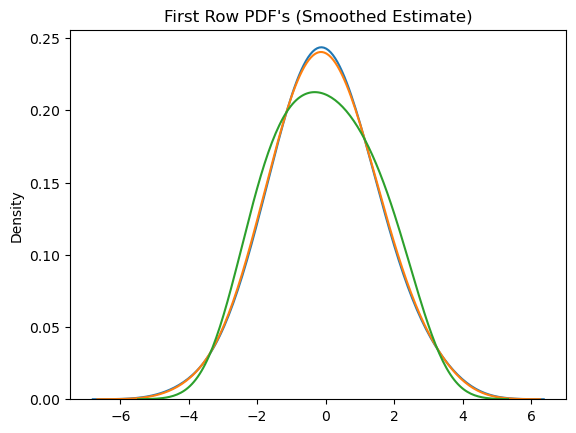

In [99]:
plt.title("First Row PDF's (Smoothed Estimate)")
for j in range(num_cols):
    sns.kdeplot(exp_map_empirical(log_f_table[0,j], ref_samples), bw_adjust=bw_adjust)
plt.show()

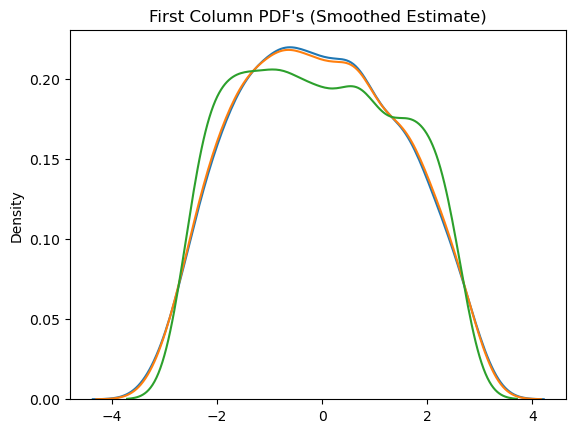

In [102]:
plt.title("First Column PDF's (Smoothed Estimate)")
for i in range(num_rows):
    sns.kdeplot(exp_map_empirical(log_f_table[i,2], ref_samples), bw_adjust=1)
plt.show()

In [107]:
data_table = [[0 for i in range(num_cols)] for j in range(num_rows)]
for i in range(num_rows):
    for j in range(num_cols):
        data_table[i][j] = exp_map_empirical(log_f_table[i,j], ref_samples)

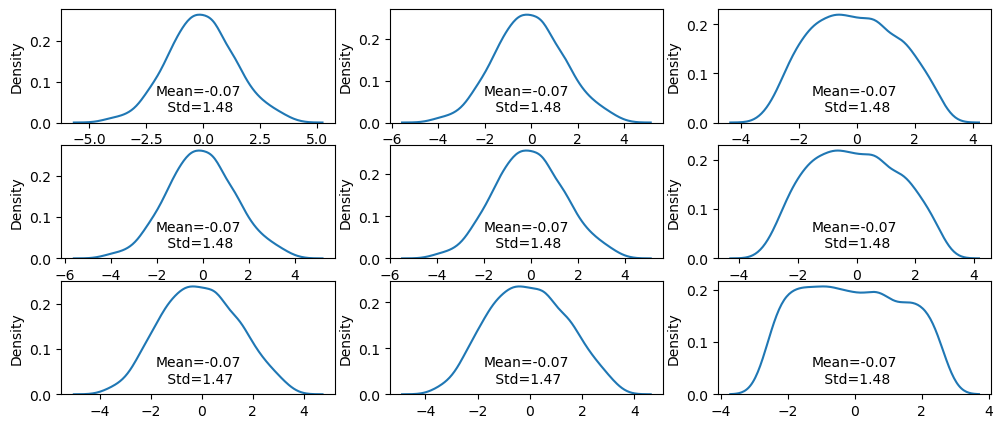

In [136]:
fig, axs = plt.subplots(num_rows, num_cols)
fig.set_figheight(5)
fig.set_figwidth(12)

for i, j in product(range(num_rows), range(num_cols)):
    data = data_table[i][j]
    sns.kdeplot(data, ax = axs[i,j], bw_adjust=1)
    axs[i,j].text(0.5,0.1, 
                  f'Mean={np.mean(data):.2f}\n Std={np.std(data):.2f}', 
                  ha='center', 
                  transform=axs[i,j].transAxes)
    
plt.savefig("data_table_unif_norm.pdf")
plt.show()

In [105]:
dissim(get_col(data_table, 0), get_col(data_table, 2))

0.04188484409478879

In [106]:
dissim(get_col(data_table, 0), get_col(data_table, 1))

0.0004188484409478877